In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import pandas as pd
import cython
from scipy.optimize import curve_fit
from lmfit.models import ExponentialModel, GaussianModel

import warnings
warnings.filterwarnings('ignore')

masses = {
    "P" : 0.93827203,
    "PIP" : 0.13957018,
    "KAON" : 0.493677
}

In [2]:
%%cython --annotate
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt
cimport cython

cdef float c_special_units = 29.9792458
cdef float MASS_PIP = 0.13957018


@cython.nonecheck(False)
@cython.cdivision(True)
cdef float dt_calc(float mass, float vertex, float momentum, float sc_t, float sc_r):
    if momentum == 0 or sc_t == 0 or sc_r == 0:
        return 100
    cdef float r_beta = 1.0 / sqrt(1.0 + (mass / momentum) * (mass / momentum))
    cdef float vt = sc_t - sc_r / (r_beta * c_special_units)
    
    return vertex - vt

@np.vectorize
def calc_dt(float mass, float vertex, float momentum, float sc_t, float sc_r):
    return dt_calc(mass, vertex, momentum, sc_t, sc_r)


In [3]:
data = pd.read_csv("/Users/tylern/Data/e1d/dt_fit.csv")
print(len(data))
data = data.replace(0, np.nan)
data = data.dropna()
print(len(data))

165444
126164


In [4]:
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r
0,4.0,0.853916,-1.420320,1.0,59.9737,0.899979,76.5669,483.698
2,1.0,0.613429,1.867490,1.0,53.5832,1.752690,71.0132,528.177
3,3.0,0.319429,-0.387466,1.0,52.8844,3.281860,69.3350,497.406
4,4.0,0.550098,-1.325840,1.0,63.7933,1.766270,81.3150,519.075
5,1.0,0.463823,1.686990,1.0,57.4559,1.920990,74.7771,504.755


In [5]:
%time
for mass in masses:
    data[f"dt_{mass}"] = calc_dt(masses[mass], data.vertex, data.p, data.sc_t, data.sc_r)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [6]:
data = data.dropna()
#data = data[(data.theta < 1.0) & (np.abs(data.dt_PIP) < 1.2)]
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r,dt_P,dt_PIP,dt_KAON
0,4.0,0.853916,-1.420320,1.0,59.9737,0.899979,76.5669,483.698,6.714813,-0.265907,1.809242
2,1.0,0.613429,1.867490,1.0,53.5832,1.752690,71.0132,528.177,2.553764,0.243858,0.873634
3,3.0,0.319429,-0.387466,1.0,52.8844,3.281860,69.3350,497.406,0.805836,0.156075,0.327744
4,4.0,0.550098,-1.325840,1.0,63.7933,1.766270,81.3150,519.075,2.084156,-0.153252,0.456379
5,1.0,0.463823,1.686990,1.0,57.4559,1.920990,74.7771,504.755,1.416630,-0.440006,0.062714


In [30]:
def two_gauss(x, *p):
    A, mu, sigma, A2, mu2, sigma2 = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    g2 = A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))
    return g1+g2

def gauss(x, *p):
    A, mu, sigma = p
    g1 = A*np.exp(-(x-mu)**2/(2.*sigma**2))
    return g1

def poly(x, a, b, c, d, e):
    # a*x**4 + b*x**3 +
    y = c*x**2 + d*x + e
    return y


def log_pol1(x, a, b, c, d, e, f):
    y = a*np.log(b*x) + c*x*np.sqrt(d*x) + e*x + f
    return y


def get_slices(data, sec=1, charge=1, min_p = 0.0, max_p = 4.0, num_steps = 120, particle="dt_P", show=False):
    slices = []
    mom = np.linspace(min_p, max_p, num=num_steps, endpoint=True)
    
    if sec != 0:
        d = data[(data.charge == charge) & (data.sec == sec)]
    else:
        d = data[(data.charge == charge)]
        
    
    for m in range(len(mom[:-1])):
        _min = mom[m]
        _max = mom[m+1]
        slic = d[(d.p > _min) & (d.p <= _max)]
        if len(slic) > 10:
            if show:
                ydata, xdata = np.histogram(slic[particle], bins=200, range=(-5,5))
                x=xdata
                y=ydata
                x = (x[1:]+x[:-1])/2.0
                
                gauss1 = GaussianModel(prefix='g1_')
                pars = gauss1.guess(y, x=x)
                pars.update(gauss1.make_params())
                pars['g1_center'].set(value=0, min=-1.0, max=1.0)
                


                gauss2 = GaussianModel(prefix='g2_')
                pars.update(gauss2.make_params())

                mod = gauss1 + gauss2

                init = mod.eval(pars, x=x)
                out = mod.fit(y, pars, x=x)

                fig, axes = plt.subplots(figsize=(12.8, 4.8))
                comps = out.eval_components(x=x)
                axes.scatter(x, y)
                axes.plot(x, comps['g1_'], 'g--', label='Gaussian component 1')
                axes.plot(x, comps['g2_'], 'm--', label='Gaussian component 2')
                #axes.plot(x, out.best_fit, 'b--', label='best fit')
                axes.legend(loc='best')
                
            else:
                ydata, xdata = np.histogram(slic[particle], bins=200, range=(-5,5))
                
            xdata = (xdata[1:] + xdata[:-1])/2.0
            try:
                p0 = [1.0, 0.0, 0.01]
                param_bounds=((0,    -0.5,  0),
                              (np.inf,0.5,  1.0)
                             )
                popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)

                if popt[2] > 0.4:
                    x2 = xdata[xdata>-0.8]
                    y2 = ydata[xdata>-0.8]
                    popt, pcov = curve_fit(gauss, x2, y2, p0=p0, bounds=param_bounds, method="trf", maxfev=10000)
                
#                 if show:
#                     plt.plot(xdata, gauss(xdata, *popt), 'r-',
#                         label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
#                     plt.legend()
                if popt[2] < 1.0 and popt[1] < 1E-5:
                    slices.append([(_min+_max)/2.0, popt[1], popt[2]])
            except RuntimeError:
                try:
                    p0 = [1.0, 0.0, 0.01]
                    param_bounds=((0,    -0.5,  0),
                                  (np.inf,0.5,  0.5)
                             )
                    popt, pcov = curve_fit(gauss, xdata, ydata, p0=p0, 
                                           bounds=param_bounds, method="trf", maxfev=10000)
#                     if show:
#                         plt.plot(xdata, gauss(xdata, *popt), 'r--',
#                              label='fit: A=%5.3f, mu=%5.3f, sigma=%5.3f' % tuple(popt))
#                         plt.legend()
                        
                    if popt[2] < 1.0 and popt[1] < 1E-5:
                        slices.append([(_min+_max)/2.0, popt[1], popt[2]])
                except RuntimeError:
                    pass
            else:
                pass
            
            if show:
                plt.show()
                
    return np.array(slices).T

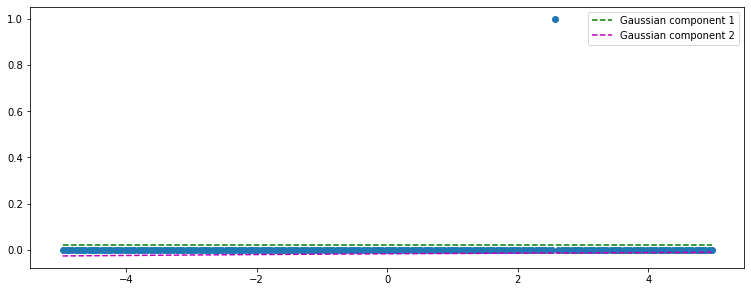

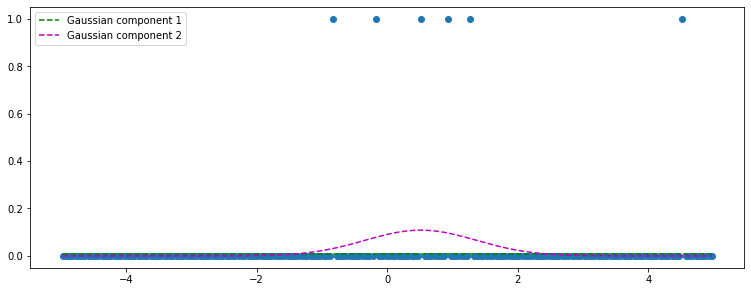

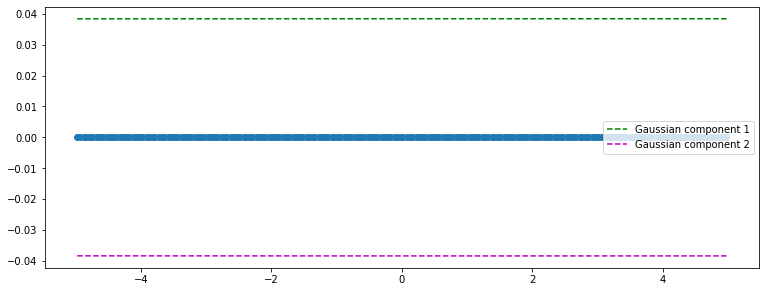

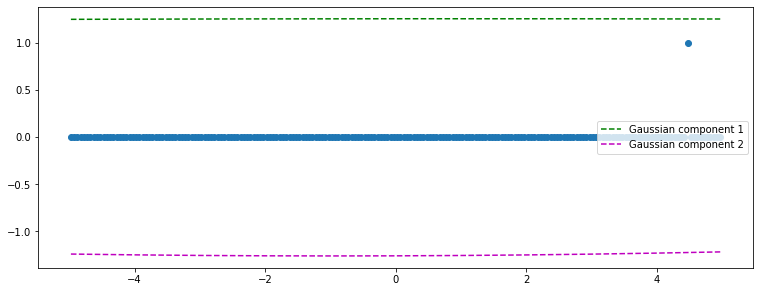

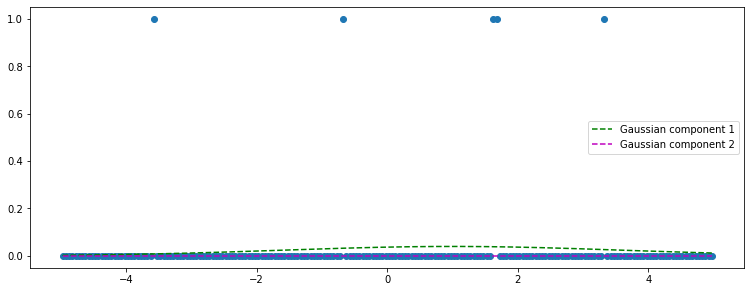

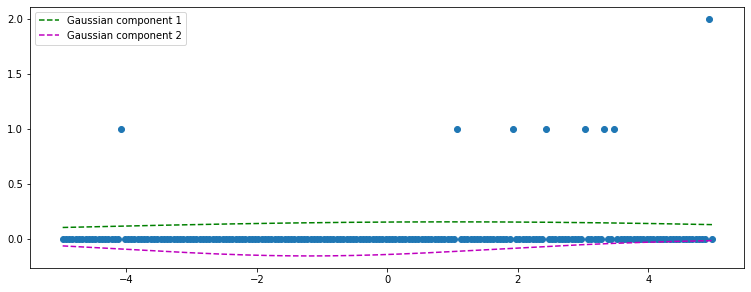

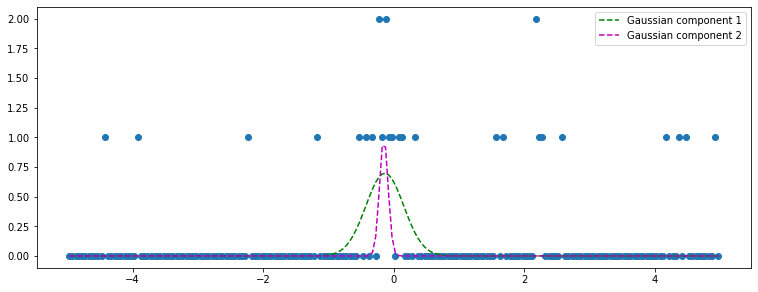

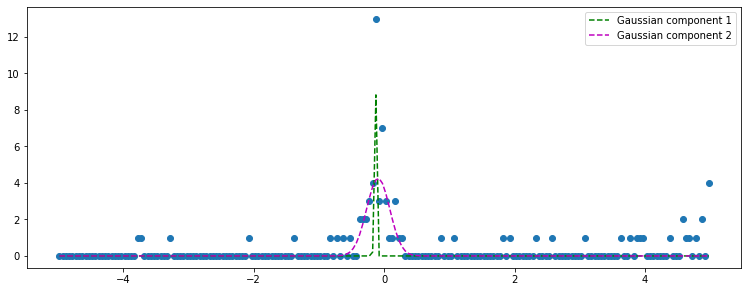

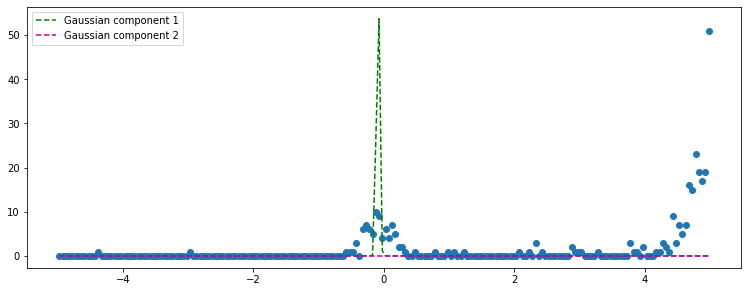

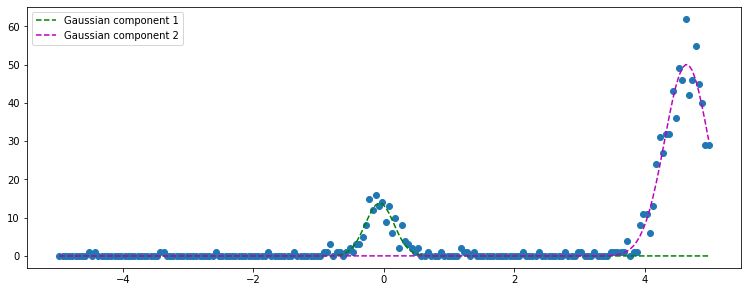

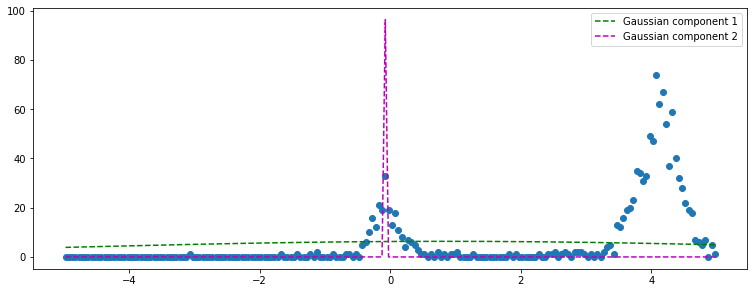

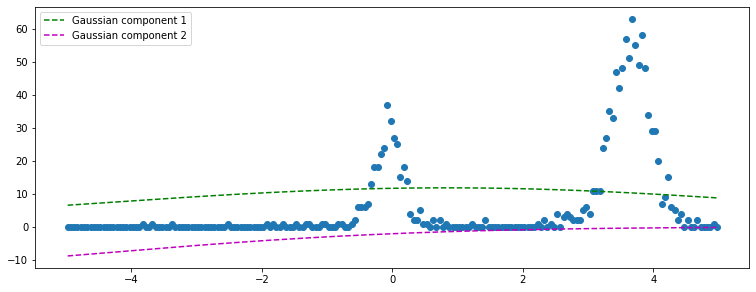

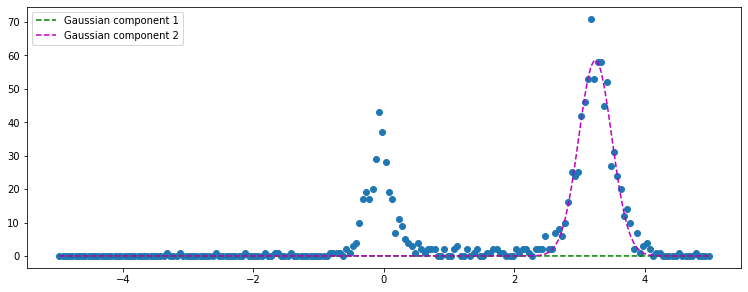

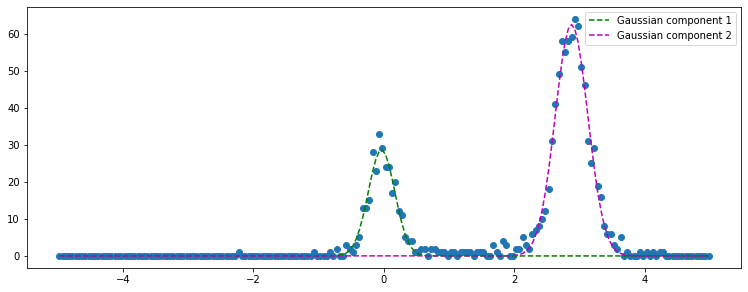

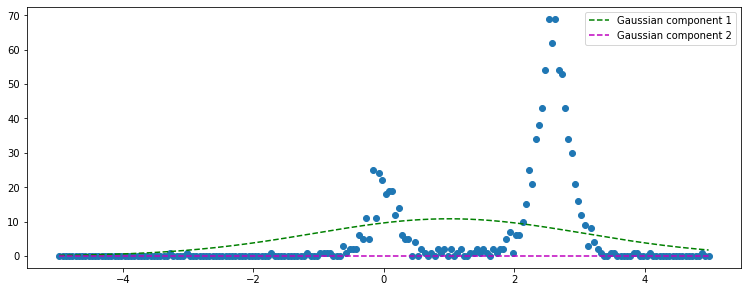

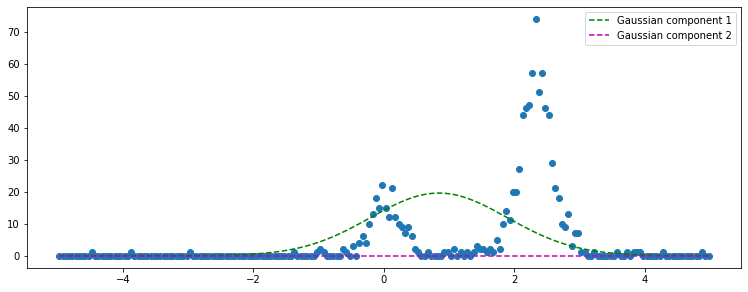

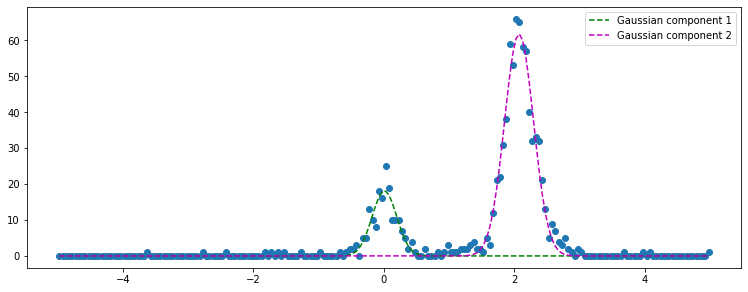

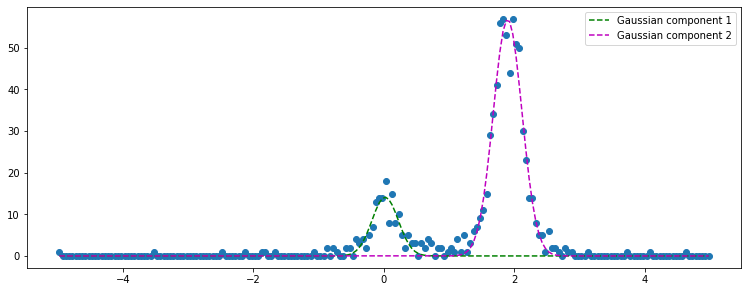

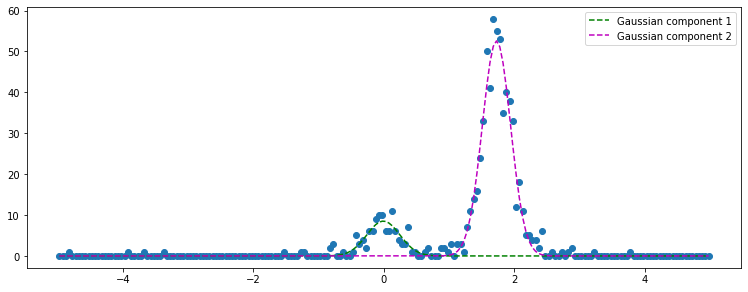

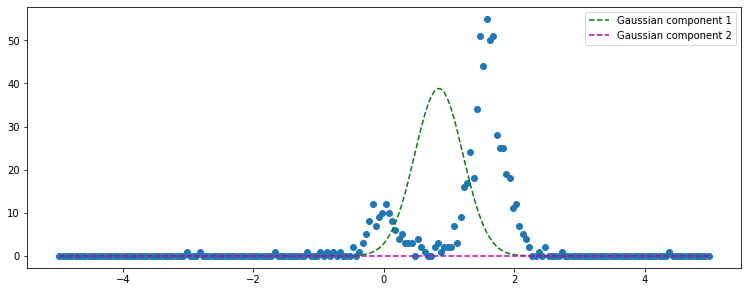

In [ ]:
slices = get_slices(data, min_p = 0.3, max_p = 2.5, num_steps = 25, show=True)

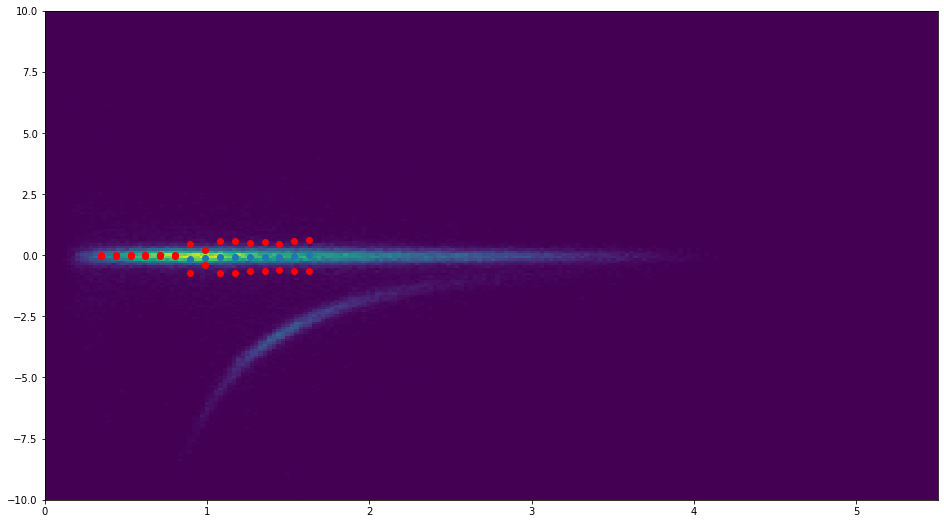

In [9]:
slice_p = slices[0]
mu = slices[1]
sigma = slices[2]

fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 5.5),(-10.0,10.0)))
plt.scatter(slice_p, mu)
plt.scatter(slice_p, mu+3*sigma, c='r')
plt.scatter(slice_p, mu-3*sigma, c='r')
plt.show()

No handles with labels found to put in legend.


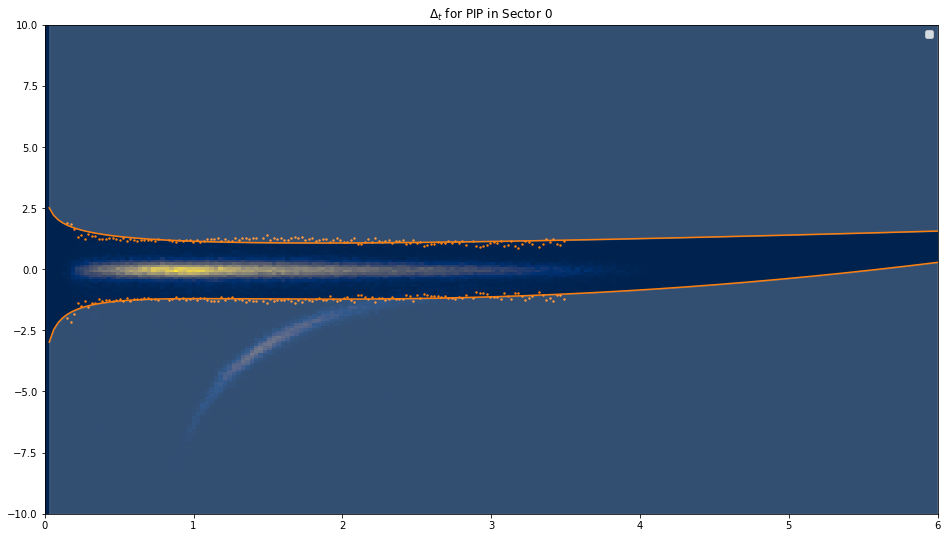

No handles with labels found to put in legend.


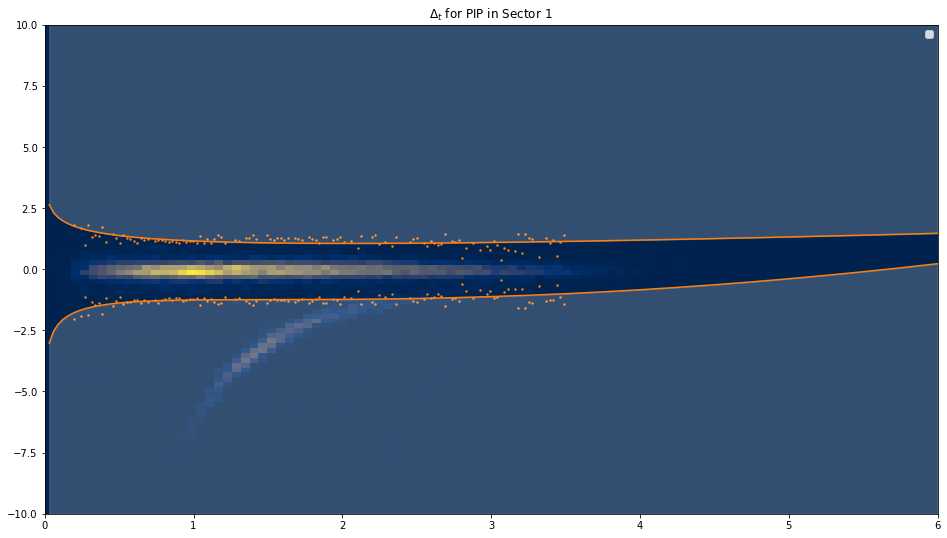

No handles with labels found to put in legend.


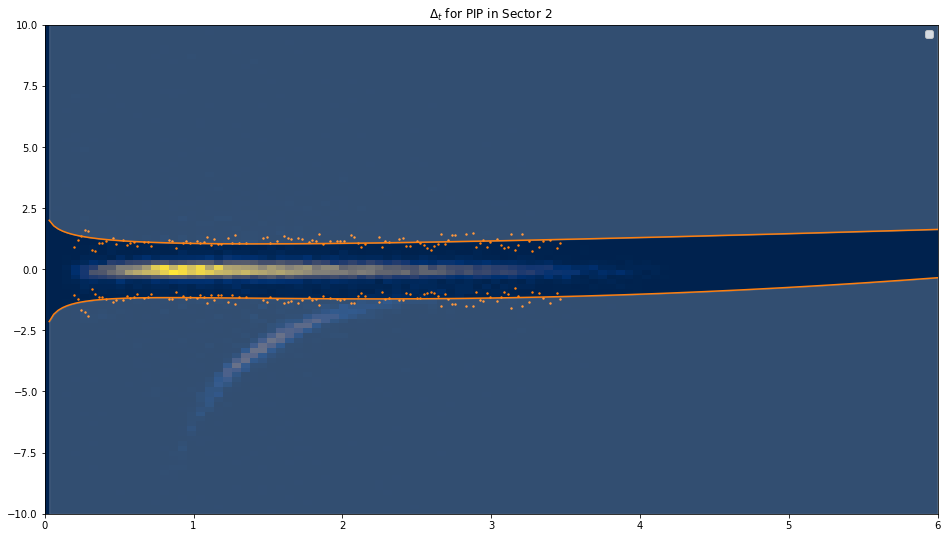

No handles with labels found to put in legend.


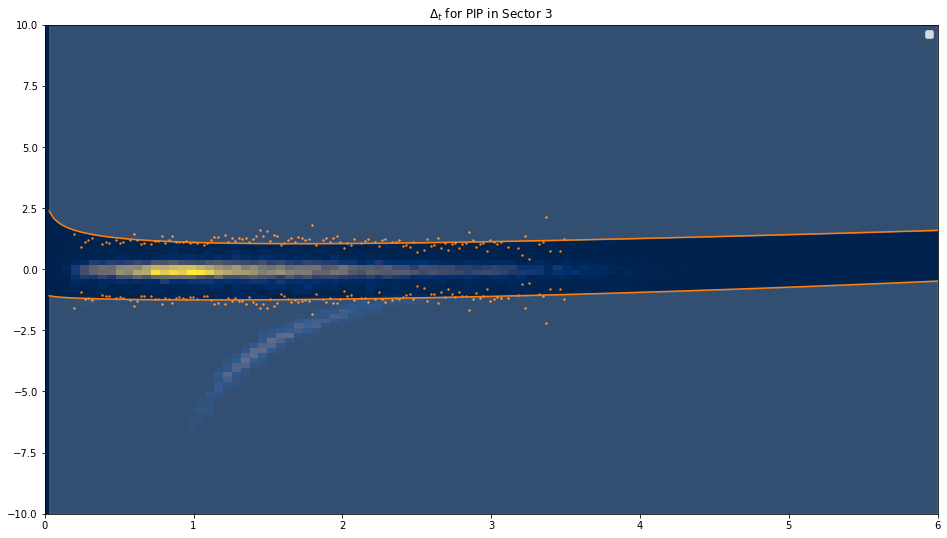

No handles with labels found to put in legend.


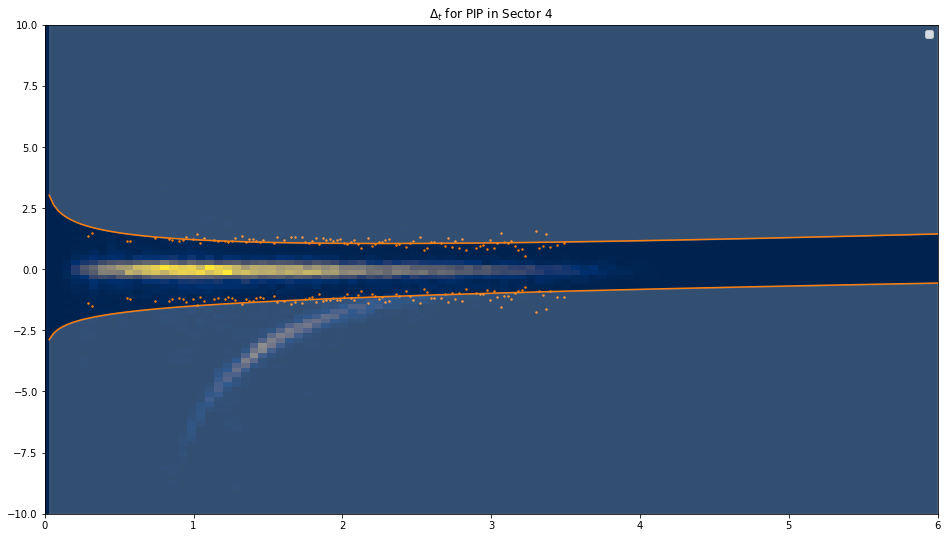

No handles with labels found to put in legend.


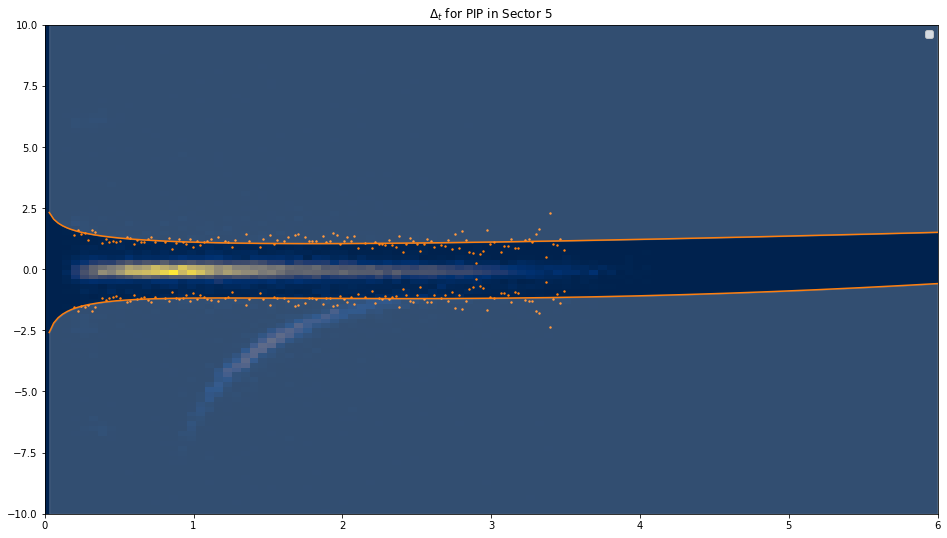

No handles with labels found to put in legend.


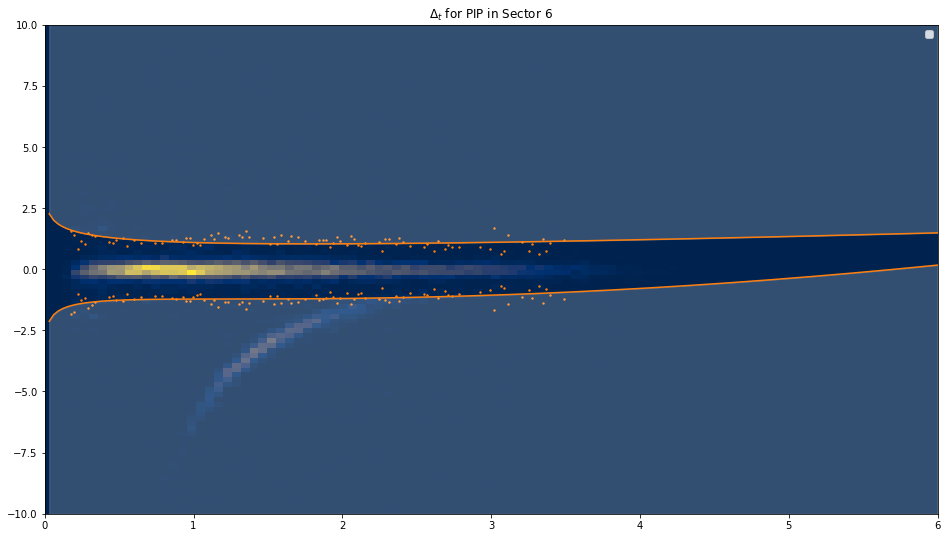

In [10]:
for part in ["dt_PIP"]:
    for i in range(0,7):
        n_sigma = 6
        slices = get_slices(data, min_p = 0.0, max_p = 3.5, num_steps = 150, sec=i, particle=part)
        slice_p = slices[0][slices[2] > 0.05]
        mu = slices[1][slices[2] > 0.05]
        sigma = slices[2][slices[2] > 0.05]

        fig = plt.figure(figsize=(16,9))
        plt.title(f"$\Delta_t$ for {part[3:]} in Sector {i}")
        if i != 0:
            plt.hist2d(data[data.sec == i].p, data[data.sec == i][part], bins=100, range=((0, 6.0),(-10.0,10.0)), cmap='cividis')
        else:
            plt.hist2d(data.p, data[part], bins=200, range=((0, 6.0),(-10.0,10.0)), cmap='cividis')
            
        #plt.scatter(slice_p, mu, s=2.0, c='#bcbd22')
        plt.scatter(slice_p, mu+n_sigma*sigma, s=2.0, c='#ff7f0e')
        plt.scatter(slice_p, mu-n_sigma*sigma, s=2.0, c='#ff7f0e')
        
        xdata = np.linspace(0,6.0,200)
        popt_top, pcov_top = curve_fit(log_pol1, slice_p, mu+n_sigma*sigma)
        plt.plot(xdata, log_pol1(xdata, *popt_top), c='#ff7f0e')
                 #,label=f'top\t{popt_top[0]:0.2f} $x^3$ + {popt_top[1]:0.2f} $x^2$ + {popt_top[2]:0.2f} x + {popt_top[3]:0.2f}')

        popt_bottom, pcov_bottom = curve_fit(log_pol1, slice_p, mu-n_sigma*sigma)
        plt.plot(xdata, log_pol1(xdata, *popt_bottom), c='#ff7f0e')
                 #,label=f'bottom\t{popt_bottom[0]:0.2f} $x^3$ + {popt_bottom[1]:0.2f} $x^2$ + {popt_bottom[2]:0.2f} x + {popt_bottom[3]:0.2f}')

        
        plt.fill_between(xdata, log_pol1(xdata, *popt_top), 10, alpha=0.2, color='white')
        plt.fill_between(xdata, log_pol1(xdata, *popt_bottom), -10, alpha=0.2, color='white')
        plt.legend()
        
        
        plt.show()
        
        #print(f"{i} top {part[3:]} {{{popt_top[0]},{popt_top[1]},{popt_top[2]},{popt_top[3]},{popt_top[4]}}}")
        #print(f"{i} bottom {part[3:]} {{{popt_bottom[0]},{popt_bottom[1]},{popt_bottom[2]},{popt_bottom[3]},{popt_bottom[4]}}}")
        

{ -0.5680719469021316,4.065155482173403,-2.285775227566277,0.09291303310648173,1.6698856065697703,0.6181398119277808}
{ 0.7021097407492168,1.1754282714198145,0.851129051933132,0.8804059391935983,-1.9632091423474742,0.22761907815192178}


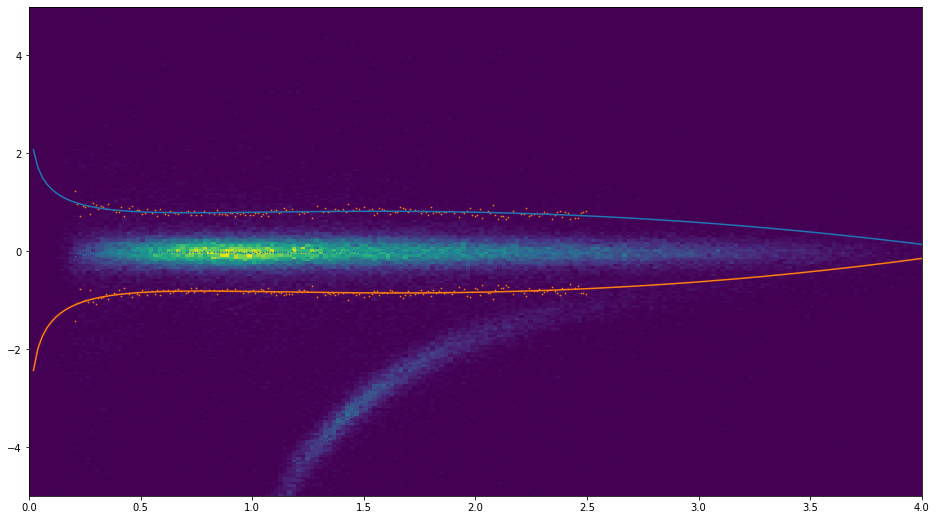

In [11]:
slices = get_slices(data, sec=0, charge=1, min_p = 0.2, max_p = 2.5, num_steps = 200, particle="dt_PIP", show=False)

slice_p = slices[0]
mu = slices[1]
sigma = slices[2]


fig = plt.figure(figsize=(16,9))
plt.hist2d(data.p, data.dt_PIP, bins=200, range=((0, 4.0),(-5.0,5.0)))
plt.scatter(slice_p, mu,s=0.5)
plt.scatter(slice_p, mu+4*sigma, c='#ff7f0e',s=0.5)
plt.scatter(slice_p, mu-4*sigma, c='#ff7f0e',s=0.5)

popt, pcov = curve_fit(log_pol1, slice_p, mu+4*sigma)
print(f"{{ {popt[0]},{popt[1]},{popt[2]},{popt[3]},{popt[4]},{popt[5]}}}")
xdata = np.linspace(0,4,200)
plt.plot(xdata, log_pol1(xdata, *popt))


popt, pcov = curve_fit(log_pol1, slice_p, mu-4*sigma)
print(f"{{ {popt[0]},{popt[1]},{popt[2]},{popt[3]},{popt[4]},{popt[5]}}}")
xdata = np.linspace(0,4,200)
plt.plot(xdata, log_pol1(xdata, *popt))

plt.show()

#print(f"{i} top {part[3:]} {{{popt_top[0]},{popt_top[1]},{popt_top[2]},{popt_top[3]},{popt_top[4]}}}")
#print(f"{i} bottom {part[3:]} {{{popt_bottom[0]},{popt_bottom[1]},{popt_bottom[2]},{popt_bottom[3]},{popt_bottom[4]}}}")



In [12]:
data.head()

,sec,theta,phi,charge,vertex,p,sc_t,sc_r,dt_P,dt_PIP,dt_KAON
0,4.0,0.853916,-1.420320,1.0,59.9737,0.899979,76.5669,483.698,6.714813,-0.265907,1.809242
2,1.0,0.613429,1.867490,1.0,53.5832,1.752690,71.0132,528.177,2.553764,0.243858,0.873634
3,3.0,0.319429,-0.387466,1.0,52.8844,3.281860,69.3350,497.406,0.805836,0.156075,0.327744
4,4.0,0.550098,-1.325840,1.0,63.7933,1.766270,81.3150,519.075,2.084156,-0.153252,0.456379
5,1.0,0.463823,1.686990,1.0,57.4559,1.920990,74.7771,504.755,1.416630,-0.440006,0.062714


[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 243
    # data points      = 2000
    # variables        = 8
    chi-square         = 173784.141
    reduced chi-square = 87.2410346
    Akaike info crit   = 8945.33356
    Bayesian info crit = 8990.14078
##  Warning: uncertainties could not be estimated:
    exp_amplitude:  at initial value
    exp_decay:      at initial value
[[Variables]]
    exp_amplitude:  0.21792998 (init = 0.21793)
    exp_decay:      0.46253103 (init = 0.462531)
    g1_amplitude:   464.324625 (init = 1)
    g1_center:     -0.01636937 (init = 0)
    g1_sigma:       0.19276393 (init = 1)
    g1_fwhm:        0.45392435 == '2.3548200*g1_sigma'
    g1_height:      960.961608 == '0.3989423*g1_amplitude/max(2.220446049250313e-16, g1_sigma)'
    g2_amplitude:   158.144593 (init = 1)
    g2_center:     -1.49786704 (init = 0)
    g2_sigma:       1.92150585 (init = 1)
 

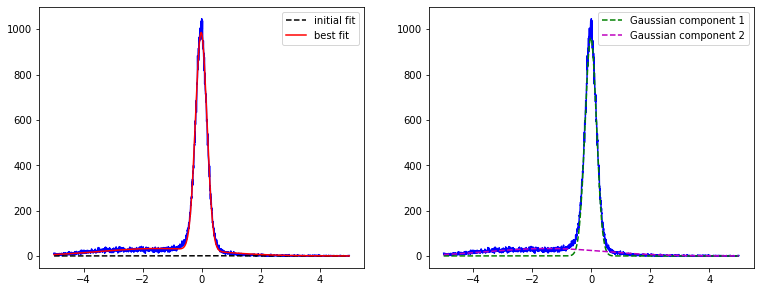

In [13]:
y, x = np.histogram(data.dt_PIP, bins=2000, range=(-5,5))
x = (x[1:]+x[:-1])/2.0


exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

#pars['g1_center'].set(value=0, min=75, max=125)
#pars['g1_sigma'].set(value=15, min=3)
#pars['g1_amplitude'].set(value=2000, min=10)

gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

mod = gauss1 + gauss2

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y, 'b')
axes[0].plot(x, init, 'k--', label='initial fit')
axes[0].plot(x, out.best_fit, 'r-', label='best fit')
axes[0].legend(loc='best')

comps = out.eval_components(x=x)
axes[1].plot(x, y, 'b')
axes[1].plot(x, comps['g1_'], 'g--', label='Gaussian component 1')
axes[1].plot(x, comps['g2_'], 'm--', label='Gaussian component 2')
#axes[1].plot(x, comps['exp_'], 'k--', label='Exponential component')
axes[1].legend(loc='best')

plt.show()